# <center> Обучение без учителя
## <center> Анализ клиентов торгового центра и выделение разных групп покупателей 

Импорт необходимых библиотек

In [74]:
import pandas as pd
from sklearn import preprocessing 
import plotly
import plotly.express as px
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_score
import seaborn as sns
from sklearn.metrics.cluster import completeness_score
#DBSCAN
from sklearn.cluster import DBSCAN

# импортируем алгомеративную кластеризацию из sklearn
from sklearn.cluster import AgglomerativeClustering



### Анализ требований

> К нам пришёл заказчик, которому необходимо проанализировать клиентов торгового центра и выделить разные группы покупателей, чтобы понять, как дальше развивать услуги торгового центра, магазины каких сегментов открывать.

В файле содержится основная информация о покупателе: идентификатор, возраст, пол, доход, индекс расходов. Индекс расходов считается на основе таких параметров, как поведение клиента и данные о покупках, и принимает значение от 1 до 100.

In [22]:
data = pd.read_csv("segmented_customers.csv")
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,1,Male,19.0,15.0,39.0,4.0
1,2,Male,21.0,15.0,81.0,3.0
2,3,Female,20.0,16.0,6.0,4.0
3,4,Female,23.0,16.0,77.0,3.0
4,5,Female,31.0,17.0,40.0,4.0


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CustomerID              205 non-null    int64  
 1   Gender                  205 non-null    object 
 2   Age                     203 non-null    float64
 3   Annual Income (k$)      203 non-null    float64
 4   Spending Score (1-100)  204 non-null    float64
 5   cluster                 201 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 9.7+ KB


In [24]:
data.dtypes

CustomerID                  int64
Gender                     object
Age                       float64
Annual Income (k$)        float64
Spending Score (1-100)    float64
cluster                   float64
dtype: object

In [25]:
print(data.isna().sum())

CustomerID                0
Gender                    0
Age                       2
Annual Income (k$)        2
Spending Score (1-100)    1
cluster                   4
dtype: int64


### Обработка пропусков и дубликатов

In [26]:
# пропусков не так много, поэтому мы можем удалить данные с пропусками

data = data.dropna()

# переименуем столбцы для более удобной работы
data.rename(columns = {'CustomerID' : 'customer_id', 'Gender' : 'gender', 
                    'Age': 'age', 'Annual Income (k$)': 'annual_income', 
                    'Spending Score (1-100)': 'spending_score', }, inplace = True)

In [27]:
data[data.duplicated(subset=['customer_id'])]


,customer_id,gender,age,annual_income,spending_score,cluster


Дубликатов нет

### Исследование данных

Чтобы мы могли визуально оценивать результаты кластеризации, будем проводить её по трём признакам, а именно: годовой заработок, коэффициент покупательской способности и возраст. 

In [68]:
fig = px.scatter_3d(
    data_frame= data,
    x = 'age',
    y = 'annual_income',
    z = 'spending_score',
    width=1000,
    height=700
)

fig.show()

Так как нам часто будет требоваться визуализировать результаты кластеризации, напишем для этого функцию.

In [32]:
def get_3d_visualization(df, clust_res):
    fig = px.scatter_3d(
        data_frame=df, 
        x = 'age', 
        y = 'annual_income', 
        z = 'spending_score', 
        color = clust_res,
        width=1000,
        height=700
    )

    #возвращаем график
    return fig

In [33]:
X = data[['age', 'annual_income', 'spending_score']]

### Моделирование

#### DBSCAN


In [54]:
clustering = DBSCAN(eps=11).fit_predict(X)
data['dbscan_res_eps=11'] = clustering

get_3d_visualization(data, 'dbscan_res_eps=11')

DBSCAN не подходит для решения данной задачи, так как наши данные распределены неоднородно: в одной области они имеют высокую плотность, а в другой области - разряжены. Поэтому дбскан отобразил некоторые данные как выбрасы(класс -1). 
Способ, основанный на плотности, не очень подходит для кластеризации.

#### Агломеративная кластеризация

In [57]:
# напишем функцию, которая будет проводить алгомеративную кластеризацию
# на вход она будет принимать X — матрицу с признаками для кластеризации и n_clusters — количество кластеров,
# на выходе будет возвращать список с номерами кластеров

def get_agglomerative_clustering(X, n_clusters):
    agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters,
                                                       linkage='ward')
    agglomerative_clustering.fit(X)
    # получим список c информацией, к какому кластеру относятся объекты
    agglomerative_pred = agglomerative_clustering.labels_
    return agglomerative_pred
    

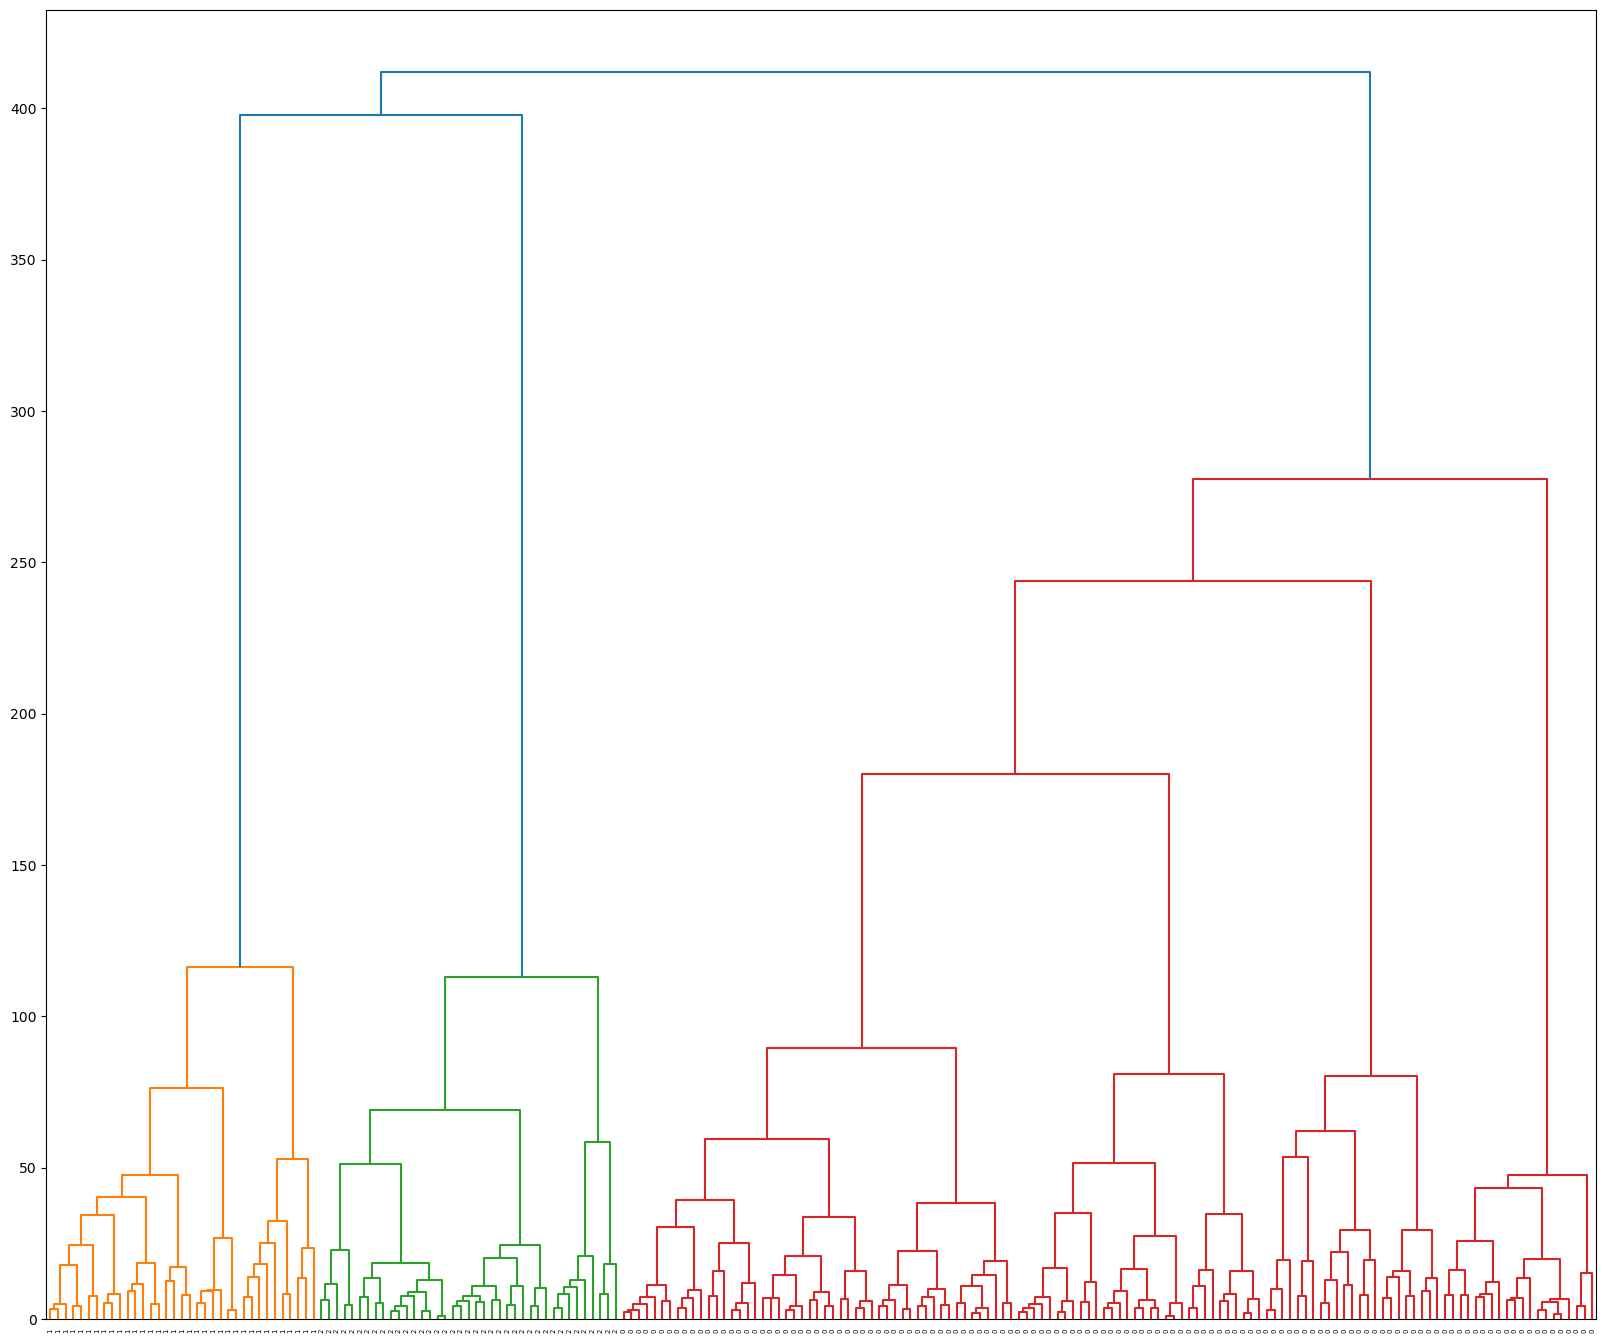

In [65]:
data['aggl_res_3'] = get_agglomerative_clustering(X, 3)

linked = linkage(X, 'ward')
plt.figure(figsize=(20, 17))

dendrogram(linked,
           orientation='top',
           labels=data['aggl_res_3'].to_list(),
           distance_sort='descending')

plt.show()

Как мы можем судить из дендрограммы, если взять евклидово расстояние между кластерами, равное 150, датасет будет делиться на шесть кластеров.

Давайте визуально оценим, что из этого получилось. Для этого обучим модель агломеративной кластеризации с количеством кластеров, равным 6:

In [67]:
data['aggl_res_6'] = get_agglomerative_clustering(data[['age', 'annual_income', 'spending_score']], 6)
get_3d_visualization(data, 'aggl_res_6')

Итак, кластеры разделились хорошо.
Теперь давайте воспользуемся коэффициентом силуэта и узнаем оптимальное количество кластеров. 

<Axes: xlabel='cluster', ylabel='silhouette'>

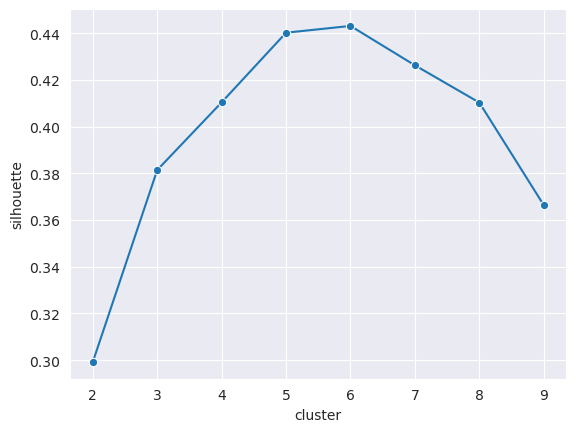

In [72]:
def get_silhouette(X, n_clusters):
    res = get_agglomerative_clustering(X, n_clusters)
    silhouette = silhouette_score(X, res)
    return silhouette

silhouette_res = {'silhouette': [], 'cluster': []}

for n_clusters in range(2, 10):
    silhouette_res['silhouette'].append(get_silhouette(X, n_clusters))
    silhouette_res['cluster'].append(n_clusters)

silhouette_data = pd.DataFrame(silhouette_res)
sns.set_style('darkgrid')
sns.lineplot(data=silhouette_data, x='cluster', y='silhouette', marker= 'o')

На графике для метода силуэта отчётливо виден пик с наибольшим значением коэффициента силуэта. Значит, оптимальное количество кластеров равно 6.

Теперь рассмотрим столбец cluster: в нём есть информация о том, к какому кластеру должен принадлежать каждый объект из датасета. Значит, мы можем проверить качество кластеризации, посчитав различные метрики.

Нам очень важно, чтобы в ходе кластеризации не были выделены лишние группы, так как это помешает анализу покупателей. Таким образом, нужно, чтобы кластеры получались максимально наполненными элементами. Используем Метрику полноты.

In [76]:
print(completeness_score(labels_true=data['cluster'], labels_pred=data['aggl_res_6']))

0.9012847747610448


Судя по значению метрики, кластеризация проведена отлично: кластеры получились наполненными элементами, а значит данные результаты можно дальше использовать для анализа.